In [1]:
import torch
import torchvision

# バージョン確認
print("torch       :", torch.__version__)
print("torchvision :", torchvision.__version__)

# GPUの確認
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device      :", device)
print(torch.version.cuda)
print(torch.cuda.device_count())
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))


torch       : 2.1.2
torchvision : 0.16.2
device      : cuda
12.1
1
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B  

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms import functional
# import cv2
# from PIL import Image
# from matplotlib import pyplot as plt
# from torch.utils.data import DataLoader
# from torch.utils.data import Dataset as BaseDataset
# # !pip install -U segmentation-models-pytorch
# import segmentation_unets_pytorch as smp


In [3]:
class TwoConvBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, middle_channels, kernel_size = 5, padding="same")
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.rl = nn.ReLU()
        self.conv2 = nn.Conv2d(middle_channels, out_channels, kernel_size = 5, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # print('forward TCB')
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.rl(x)
        # print('first TCB, x: ', x.shape)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.rl(x)
        # print('second TCB, x: ', x.shape)
        return x

class UNet_2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.TCB1 = TwoConvBlock(150, 150, 150)
        self.TCB2 = TwoConvBlock(150, 150, 150)
        self.maxpool = nn.MaxPool2d(2, stride = 2)
        self.flatten = nn.Flatten(2, -1)
        self.linear = nn.Linear(1200, 2)
        
        # self.conv1 = nn.Conv2d(64, 4, kernel_size = 1)
        # self.soft = nn.Softmax(dim = 1)

    def forward(self, x):
        # print('forward')
        # print('x0: ', x)
        x = self.TCB1(x)
        # x1 = x
        x = self.maxpool(x)
        # print('x1: ', x1.shape)

        x = self.TCB2(x)
        # x2 = x
        x = self.maxpool(x)
        # print('x2: ', x2.shape)

        x = self.TCB2(x)
        # x3 = x
        x = self.maxpool(x)
        # print('x3: ', x3.shape)

        x = self.TCB2(x)
        # x4 = x
        x = self.maxpool(x)
        # print('x4: ', x4.shape)
        
        x = self.flatten(x)
        # x5 = x
        # print('x5: ', x5.shape)

        x = self.linear(x)
        # x6 = x
        # print('x6: ', x6.shape)

        return x


class EarlyStopping:
    """earlystoppingクラス"""

    def __init__(self, patience=5, verbose=False, path='checkpoint_model.pth'):
        """引数：最小値の非更新数カウンタ、表示設定、モデル格納path"""

        self.patience = patience    #設定ストップカウンタ
        self.verbose = verbose      #表示の有無
        self.counter = 0            #現在のカウンタ値
        self.best_score = None      #ベストスコア
        self.early_stop = False     #ストップフラグ
        self.val_loss_min = np.Inf   #前回のベストスコア記憶用
        self.path = path             #ベストモデル格納path

    def __call__(self, val_loss, model):
        """
        特殊(call)メソッド
        実際に学習ループ内で最小lossを更新したか否かを計算させる部分
        """
        score = -val_loss

        if self.best_score is None:  #1Epoch目の処理
            self.best_score = score   #1Epoch目はそのままベストスコアとして記録する
            self.checkpoint(val_loss, model)  #記録後にモデルを保存してスコア表示する
        elif score < self.best_score:  # ベストスコアを更新できなかった場合
            self.counter += 1   #ストップカウンタを+1
            if self.verbose:  #表示を有効にした場合は経過を表示
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')  #現在のカウンタを表示する 
            if self.counter >= self.patience:  #設定カウントを上回ったらストップフラグをTrueに変更
                self.early_stop = True
        else:  #ベストスコアを更新した場合
            self.best_score = score  #ベストスコアを上書き
            self.checkpoint(val_loss, model)  #モデルを保存してスコア表示
            self.counter = 0  #ストップカウンタリセット

    def checkpoint(self, val_loss, model):
        '''ベストスコア更新時に実行されるチェックポイント関数'''
        if self.verbose:  #表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  #ベストモデルを指定したpathに保存
        self.val_loss_min = val_loss  #その時のlossを記録する



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Using cuda device


wandb: Currently logged in as: gen0401. Use `wandb login --relogin` to force relogin


[Epoch 1]
Data No.00416 was loadedbatch:  0
Data No.00582 was loadedbatch:  1
Data No.00065 was loadedbatch:  2
Data No.00835 was loadedbatch:  3
Data No.00585 was loadedbatch:  4
Data No.00553 was loadedbatch:  5
Data No.00210 was loadedbatch:  6
Data No.00736 was loadedbatch:  7
Data No.00844 was loadedbatch:  8
Data No.00984 was loadedbatch:  9
Data No.00215 was loadedbatch:  10
Data No.00315 was loadedbatch:  11
Data No.00486 was loadedbatch:  12
Data No.00143 was loadedbatch:  13
Data No.00766 was loadedbatch:  14
Data No.00012 was loadedbatch:  15
Data No.00352 was loadedbatch:  16
Data No.00073 was loadedbatch:  17
Data No.00058 was loadedbatch:  18
Data No.00590 was loadedbatch:  19
Data No.00427 was loadedbatch:  20
Data No.00111 was loadedbatch:  21
Data No.00852 was loadedbatch:  22
Data No.00229 was loadedbatch:  23
Data No.00336 was loadedbatch:  24
Data No.00285 was loadedbatch:  25
Data No.00329 was loadedbatch:  26
Data No.00888 was loadedbatch:  27
Data No.00440 was lo

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test_loss,▁
train_loss,▁
test_loss,829387.6875
train_loss,744881.625


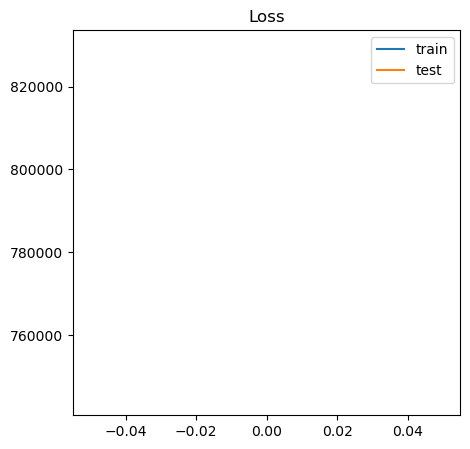

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import wandb
# from model import E2VIDRecurrent, E2VID
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import glob

# 変更する必要のある変数
TITLE = "BrandSilence"
num_bin = 150

input_path = './Dataset/train_data/'
target_path = './Dataset/validation_data/'
SIZE_X = 640
SIZE_Y = 480
learning_rate = 0.0001
epochs = 8
Loss = "MSE"
activation = "ReLU"
batch_size=6
norm = "BN"
flip_lr = 0.4
flip_ud = 0.4

now = datetime.now()
plt.figure(figsize=(5, 5))
plt.title("Loss")
train_loss = []
test_loss = []


# 損失関数の記述
# TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)
# BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
# def criterion(pred,target):
#     return 0.5*BCELoss(pred, target) + 0.5*TverskyLoss(pred, target)

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

class CustomImageDataset(Dataset):
    def __init__(self, input_dir, target_dir, title):
        self.dir_input = input_dir
        self.dir_target = target_dir
        self.title = title

    def __len__(self):
        return len(glob.glob(self.dir_target + f"*_{num_bin}.npz"))

    def __getitem__(self, idx):
        #rd_lr = random.random()
        #rd_ud = random.random()
        input_path = self.dir_input + self.title + str(idx).zfill(5) + f"_{num_bin}.npz"
        input_loaded = np.load(input_path)
        input = input_loaded['arr_0']
        target_path = self.dir_target + self.title + str(idx).zfill(5) + f"_{num_bin}.npz"
        target = np.load(target_path)['arr_0']
        print("\rData No." + str(idx).zfill(5) + " was loaded", end="")
        """
        if(rd_lr < flip_lr):
            input = input[:, ::-1, :]
            target = target[:, ::-1]
        if(rd_ud < flip_ud):
            input = input[::-1, :, :]
            target = target[::-1, :, :]
        """
        return input, target

"""
transform = T.Compose(
    [T.RandomHorizontalFlip(p=0.5),
     T.RandomVerticalFlip(p=0.5),
     T.RandomRotation(degrees=(-20, 20))]
)
"""

dataset = CustomImageDataset(input_dir=input_path, target_dir=target_path, title=TITLE)
# print(len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 50, 50])
# print(len(train_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# print(train_dataloader)
# print(test_dataloader)

data_num = len(train_dataset)
parameters = "aug_bin" + str(num_bin) \
    + "_batch" + str(batch_size) \
        + "_normdata" + str(data_num)  \
            + "_lr" + str(learning_rate).split('.')[1] \
                + "_" + activation \
                    + "_" + Loss \
                        + "_epoch"+ str(epochs) \
                            + "_Norm" + str(norm)
save_model = "./Dataset/pretrained/model_" + parameters + ".pth"

wandb.init(
    project = "event-based_NLOS",

    name = parameters,

    config={
        "train_data_num": data_num,
        "learning_rate": learning_rate,
        "activation": activation,
        "train_loss": Loss,
        "epochs": epochs,
        "num_bin": num_bin,
        "batches": batch_size,
        "Norm": norm
    }
)

def train(dataloader, model, loss_fn, optimizer, epoch_num, batch):
    model.train()
    # X: input, y: target
    for batch, (X, y) in enumerate(dataloader):
        print('batch: ', batch)
        X, y = X.to(device).to(torch.float), y.to(device).to(torch.float)
        # print(y.shape)

        # Compute prediction error
        # print('---------------------\n\n\n')
        # print('X: ', X)
        # print('y: ', y)
        pred = model(X)
        loss = loss_fn(pred, y)
        #loss = torch.sum(loss)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    loss_num = loss.item()
    # writer.add_scalar("Train_Loss", loss_num, epoch_num)
    wandb.log({"train_loss": loss_num})
    print('last batch value: ', batch)
    print('loss_num: ', loss_num)
    train_loss.append(loss_num)


def test(dataloader, model, loss_fn, epoch_num):
    model.eval()
    with torch.no_grad():
        i=0
        for X, y in dataloader:
            X, y = X.to(device).to(torch.float), y.to(device).to(torch.float)
            pred = model(X)
            loss = loss_fn(pred, y)
            i += 1
    
    loss_num = loss.item()
    #writer.add_scalar("Test_Loss", loss_num, epoch_num)
    wandb.log({"test_loss": loss_num})
    test_loss.append(loss_num)

def main():
    start = datetime.now()

    # define model
    unet = UNet_2D().to(device)
    
    #train_loss_fn = lpips.LPIPS(net='vgg').cuda().forward
    train_loss_fn = nn.MSELoss()
    test_loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(unet.parameters(), lr=learning_rate)

    for t in range(epochs):
        print(f"[Epoch {t+1}]")
        train(train_dataloader, unet, train_loss_fn, optimizer, t, batch_size)
        test(test_dataloader, unet, test_loss_fn, t)
        print("\n-------------------------------")
    end = datetime.now()
    print("Done!")
    torch.save(unet, save_model)
    print("Saved PyTorch Model: " + save_model)
    print("Start: " + start.strftime("%Y%m%d-%H%M%S"))
    print("End: " + end.strftime("%Y%m%d-%H%M%S"))

    #writer.close()
    wandb.finish()
    plt.plot(train_loss, label='train')
    plt.plot(test_loss, label='test')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    main()
